In [1]:
%load_ext autoreload
%autoreload 2

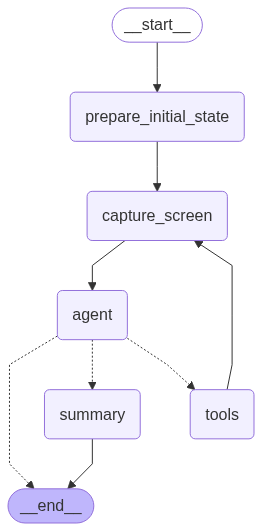

In [2]:
from src.agents.openai import create_openai_agent
from IPython.display import Image, display

agent = await create_openai_agent(server_name="mouse")
display(Image(agent.get_graph().draw_mermaid_png()))

In [3]:
prompt = """
You need to solve this following task. Using the current state screenshot you need to ensure that the task is completed. 
If you click in any button it returns success if the click was done, but it does not mean the button was pressed because you could failed aiming it, to ensure that check the current state. 
If you haven't solved the task keep trying until you are completely sure that it is solved.

Click on select button and move to the next screen to start playing a hand. Tell me what is the last tool you executed and what is the result. 
Also describe the screen that you obtain at the end. Is the task completed?

This is the position of the select button:
{'polygons': [[[576.9599609375, 341.82000732421875, 801.5999755859375, 341.82000732421875, 801.5999755859375, 393.6600036621094, 576.9599609375, 393.6600036621094]]], 'polygons_labels': ['select button']}
"""

res = await agent.ainvoke({"messages": [{"role": "user", "content": prompt}]})
res.keys()

dict_keys(['initial_task', 'last_screenshot', 'ai_message', 'last_ai_with_tools', 'last_tool_message', 'messages', 'recursion_count'])

In [4]:
res['last_ai_with_tools'].additional_kwargs

{'tool_calls': [{'id': 'call_imfWO2YJLamZ0C4XyNlw99EN',
   'function': {'arguments': '{"x":960,"y":270}', 'name': 'mouse_click'},
   'type': 'function'}],
 'refusal': None}

In [12]:
print(res['ai_message'].content)

The last tool I executed was functions.mouse_click at pixel coordinates (960, 270), which is the center of the "Select" button for the Small Blind.

Result: The click was successful, but the screen state did not change. The game is still on the "Choose your next Blind" screen, indicating that the button was not pressed (the click did not register on the button).

Screen description:
- The game is prompting to choose the next Blind.
- "Select" button for Small Blind is highlighted.
- Big Blind and The Window are upcoming and not selectable.
- You have 5 hands, 3 discards, $4, Ante 1/8, Round 0.
- The deck shows 52/52 cards.

Task status: Not completed. I have not moved to the next screen to start playing a hand. The "Select" button needs to be clicked more precisely.


In [1]:
from langchain_mcp_adapters.client import MultiServerMCPClient

client = MultiServerMCPClient({
    "output_handling":{"image":"content"},
    "use_standard_content_blocks": True,
    "mouse": {
        "transport": "streamable_http",
        "url": "http://localhost:8001/mouse/mcp",
    },
    "gamepad": {
        "transport": "streamable_http",
        "url": "http://localhost:8001/gamepad/mcp"
    }
})

tools = await client.get_tools(server_name="mouse")
screen_tool = None
locate_tool = None
for t in tools:
    print(t.name, t.description)
    if t.name == "get_screen_with_cursor":
        screen_tool = t
    if t.name == "locate_element":
        locate_tool = t

locate_element Locate an element on the screen by a brief description.
mouse_click Click at a specific coordinate on the screen using pixel coordinates. Screen resolution: 1920x1080 pixels. Use exact pixel coordinates for precise clicking.
mouse_drag Drag the mouse from start coordinates to end coordinates using pixel coordinates. Screen resolution: 1920x1080 pixels. Use exact pixel coordinates for precise dragging.
get_screen_with_cursor Get a screenshot with cursor position visible. The cursor is a light green point inside a larger dark green circle, to make it more visible. Use this to see the current game state and plan your next mouse actions using pixel coordinates. Screen resolution: 1920x1080 pixels. 


In [11]:
import json

location = json.loads(await locate_tool.arun({"description": "select button"}))
location

In [12]:
location

{'status': 'error',
 'message': "Error locating element: 'Florence2ForConditionalGeneration' object has no attribute '_supports_sdpa'"}

In [2]:
import json

res = json.loads(await screen_tool.ainvoke(input={}))
base64_image = res['screenshot'].split(",")[1]
print(res.keys())

dict_keys(['screenshot', 'mouse_info'])


In [3]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM 
import io
import base64

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = AutoModelForCausalLM.from_pretrained("AskUI/PTA-1", torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("AskUI/PTA-1", trust_remote_code=True)

task_prompt = "<OPEN_VOCABULARY_DETECTION>"
prompt = task_prompt + "run info and options"

# Cargar imagen desde base64
image_bytes = base64.b64decode(base64_image)
image = Image.open(io.BytesIO(image_bytes)).convert("RGB")

inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3,
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task="<OPEN_VOCABULARY_DETECTION>", image_size=(image.width, image.height))

print(parsed_answer)

/home/javi/miniconda3/envs/jokernet/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [], 'bboxes_labels': [], 'polygons': [[[93.1199951171875, 705.780029296875, 219.83999633789062, 705.780029296875, 219.83999633789062, 853.7400512695312, 93.1199951171875, 853.7400512695312]]], 'polygons_labels': ['run info and options']}}


In [5]:
from PIL import Image
import json
import io
import base64

tools = await client.get_tools(server_name="mouse")
screen_tool = next((t for t in tools if t.name == "get_screen_with_cursor"), None)
cursor_tool = next((t for t in tools if t.name == "get_mouse_position"), None)
image_content = json.loads(await screen_tool.ainvoke(input={}))
image_data = image_content[0]["image_url"].split(",")[1]
image_bytes = base64.b64decode(image_data)
Image.open(io.BytesIO(image_bytes))

print("Cursor Tool Result:", await cursor_tool.ainvoke(input={}))

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7bbfcaef2d90>

In [47]:
import requests
from fastmcp.utilities.types import Image

res = requests.get("http://localhost:8000/screenshot_with_cursor")
Image(data=res.content, format="png")